# Tour of ProblY

This Python module was written to overcome some limitations of `scipy.stats`. Most importantly, this is done by obeying the following principle:
> Random variables should be treated as **numeric types**.

This means treating them as objects that can be composed with functions of a number, array, or matrix and, in particular, allowing arithmetical operations to be performed upon them.

On the other hand, the implementation of random variables in `scipy.stats` is geared towards statistical (rather than probabilistic) applications, and therefore emphasizes their distribution and other properties, which may be unknown in many cases of potential interest. Moreover, many random variable classes in `scipy.stats` are actually *families* of random variables. Again, this is done due to the focus on statistical applications, where the exact distribution is being seeked within a family of distributions. However, when such applications are not the main focus, this can be cumbersome and somewhat unnatural.

The main object in ProblY is the `probly.sampler` class, which implements a very general kind of random variable: a numerical object that outputs values according to some procedure in response to a seed quantity: such an implementation brings together the following two actually quite similar perspectives on what a random variable does: the programmer's perspective, where a random variable transforms a seed into some other object according to some algorithm; and the mathematician's perspective, in which a random variable is viewed as an abstract (measurable) map into a space of numbers, vectors, etc.

## Examples

We need the following modules.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from probly import sampler, Lift

### 1. Compatibility with `scipy.stats`
Random variables from `scipy.stats` can be wrapped in a `sampler` object as follows.

In [13]:
n = stats.norm()
N = sampler(n)

Samples are drawn by calling the random variable. If an argument is provided, it acts as the random seed.

In [14]:
print(N())
print(N() == N())
print(N(10) == N(10))

-1.33844353049
False
True


### 2. Constant random variables

The simplest example is a constant random variable.

In [15]:
C1 = sampler(8)
print('C1 = ', C1())

C2 = sampler([[1, 2], [3, 4]])
print('C2 = ', C2())

C3 = sampler(np.array([1, 2, 3, 4]))
print('C3 = ', C3())

C1 =  8
C2 =  [[1 2]
 [3 4]]
C3 =  [1 2 3 4]


### 3. Arithmetic with random variables

Basic arithmetical operations can be performed on and between random variables.

In [16]:
X = 100 + sampler(stats.norm())
print(X())

98.0173840136


In [17]:
Y = 40 * sampler(stats.norm())
print((X + Y)())

94.9849585674


### 4. Matrix-valued random variables

Matri-valued random variables behave just like matrices.

In [18]:
M = sampler(stats.wishart(scale=np.eye(2)))
Z = np.dot(M, M)
print(Z[0, 0]())

2.5374081351


### 4. Functions of random variables

Any function between numerical types can be extended to act on random variables (by composition) with `probly.Lift`.

In [19]:
from probly import Lift
Trace = Lift(np.trace)
T = Trace(Z)
print(T())

5.7723929729


### 5. Leading eigenvalue of a random Wishart matrix

We can use the `scipy.stats.wishart` implementation of random Wishart matrices to sample their leading eigenvalues and construct a histogram.

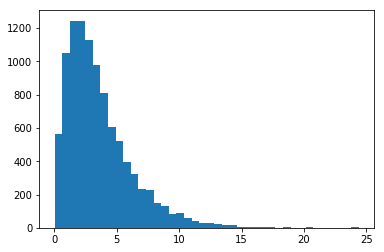

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def largest_eig(matrix):
    return np.max(np.linalg.eig(matrix)[0])
largest_eig = Lift(largest_eig)

Lambda = largest_eig(stats.wishart(scale=np.eye(2)))
samples = [Lambda() for _ in range(10000)]
_ = plt.hist(samples, bins=40)